In [2]:
import ast
import json
import re
import string
import time
import sys
import datetime
import contextlib
import os
from datetime import timedelta

import requests
import ssl
import tempfile
from io import StringIO

import pandas as pd
import numpy as np
import glob
from pathlib import Path


import datetime
import seaborn as sns
# from minepy import MINE
# from heapq import merge

import matplotlib.pyplot as plt

import seaborn as sns
from statsmodels.tsa.seasonal import STL, seasonal_decompose
# from meteostat import Point, Daily, Hourly
from dateutil.relativedelta import relativedelta

from dateutil import relativedelta
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler


In [3]:
fileAll="Z:\Dropbox (PowerMarketsUR)\Moscow Office\ERCOT\MCC_INFLUENCE\spp\model\dataset/CSWS.VOLT.0124_final.csv"
data = pd.read_csv(fileAll, low_memory=False)
data['Data'] = pd.to_datetime(data['Data'], format='%Y-%m-%d')
data

,Year,Month,Day,Hour,Wind,Coal,Load,NaturalGas,PriceGaz,temp,...,wdir,wspd,pres,Price,Peak,Data,temp_mean,wspd_mean,pres_mean,Season
0,2022,4,1,0,11261.300,9906.600,27364.785,4318.000,5.43,11.1,...,310.0,9.4,1012.6,1.1016,0.0,2022-04-01 00:00:00,17.0,23.0,1012.0,Spring
1,2022,4,1,1,12656.000,9607.008,27144.399,2899.783,5.43,7.8,...,40.0,5.4,1012.8,1.9007,0.0,2022-04-01 01:00:00,17.0,23.0,1012.0,Spring
2,2022,4,1,2,13150.708,9300.617,27117.422,2830.575,5.43,7.2,...,0.0,0.0,1013.4,3.8994,0.0,2022-04-01 02:00:00,17.0,23.0,1012.0,Spring
3,2022,4,1,3,13862.425,8811.367,27297.655,2771.042,5.43,3.9,...,0.0,0.0,1014.1,2.9296,0.0,2022-04-01 03:00:00,17.0,23.0,1012.0,Spring
4,2022,4,1,4,14428.500,9045.167,27823.858,2950.642,5.43,3.3,...,0.0,0.0,1014.1,2.3903,0.0,2022-04-01 04:00:00,17.0,23.0,1012.0,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,2022,12,5,20,14826.017,9395.525,31581.974,5166.950,4.15,21.1,...,180.0,14.8,1003.8,6.7448,1.0,2022-12-05 20:00:00,7.0,17.0,1021.0,Autumn
5955,2022,12,5,21,14789.983,9243.925,30703.545,5001.975,4.15,22.0,...,192.0,5.8,1005.0,7.0492,1.0,2022-12-05 21:00:00,7.0,17.0,1021.0,Autumn
5956,2022,12,5,22,14513.882,9112.755,29445.211,4698.318,4.15,17.2,...,50.0,16.6,1005.2,6.4345,0.0,2022-12-05 22:00:00,7.0,17.0,1021.0,Autumn
5957,2022,12,5,23,13848.800,8822.542,28184.356,4397.092,4.15,13.3,...,60.0,14.8,1006.3,11.0744,0.0,2022-12-05 23:00:00,7.0,17.0,1021.0,Autumn


### 1  Простая модель

In [104]:
column = ['Data','Price', "Wind", "Coal","Load","NaturalGas","PriceGaz","temp_mean", 'wdir']
dataTMP = data[column]
dataTMP

,Data,Price,Wind,Coal,Load,NaturalGas,PriceGaz,temp_mean,wdir
0,2022-04-01 00:00:00,1.1016,11261.300,9906.600,27364.785,4318.000,5.43,17.0,310.0
1,2022-04-01 01:00:00,1.9007,12656.000,9607.008,27144.399,2899.783,5.43,17.0,40.0
2,2022-04-01 02:00:00,3.8994,13150.708,9300.617,27117.422,2830.575,5.43,17.0,0.0
3,2022-04-01 03:00:00,2.9296,13862.425,8811.367,27297.655,2771.042,5.43,17.0,0.0
4,2022-04-01 04:00:00,2.3903,14428.500,9045.167,27823.858,2950.642,5.43,17.0,0.0
...,...,...,...,...,...,...,...,...,...
5954,2022-12-05 20:00:00,6.7448,14826.017,9395.525,31581.974,5166.950,4.15,7.0,180.0
5955,2022-12-05 21:00:00,7.0492,14789.983,9243.925,30703.545,5001.975,4.15,7.0,192.0
5956,2022-12-05 22:00:00,6.4345,14513.882,9112.755,29445.211,4698.318,4.15,7.0,50.0
5957,2022-12-05 23:00:00,11.0744,13848.800,8822.542,28184.356,4397.092,4.15,7.0,60.0


In [105]:
# Выбор признаков
x = datetime.datetime(2020, 1, 1)
y = datetime.datetime(2022, 10, 10)
z = datetime.datetime(2022, 12, 10)


dataTrain = dataTMP[(dataTMP['Data'] >= x) & (dataTMP['Data'] < y) ].copy()
dataPred = dataTMP[(dataTMP['Data'] >= y) & (dataTMP['Data'] < z)].copy()


y_train = dataTrain['Price'].copy()
X_train = dataTrain.drop(["Data", 'Price'], axis=1).copy()

y_test = dataPred['Price'].copy()
X_test = dataPred.drop(["Data", 'Price'], axis=1).copy()


In [106]:
reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_pred = reg.predict(X_test)

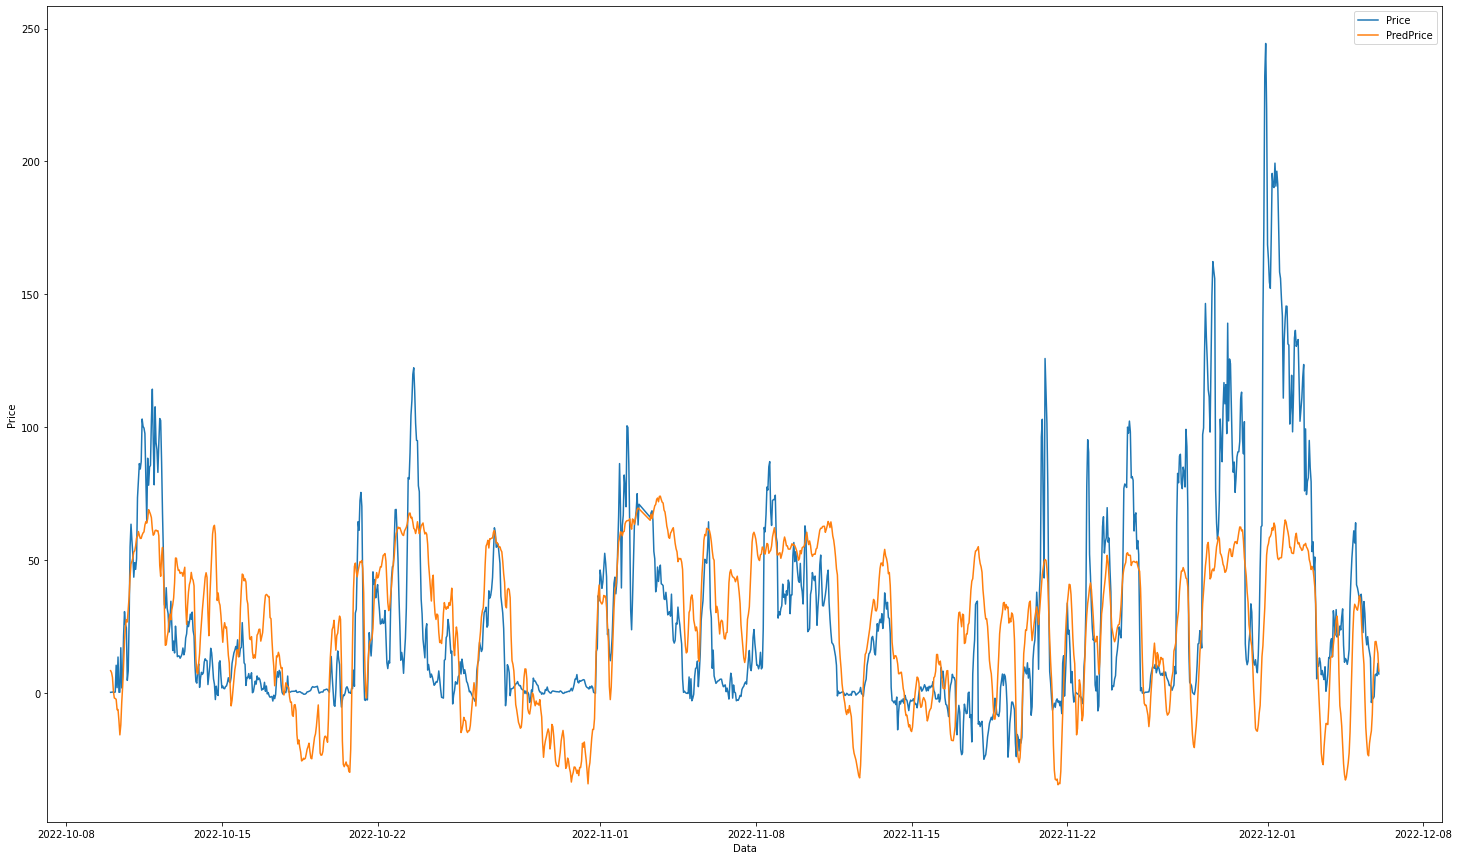

In [107]:
priceTest = pd.DataFrame(y_test, columns = ["Price"])
priceTest['PredPrice'] = y_pred
priceTest['Data'] = dataPred["Data"]


plt.rcParams['figure.figsize'] = (25,15)
sns.lineplot(data=priceTest, x='Data', y='Price', label="Price")
sns.lineplot(data=priceTest, x='Data', y='PredPrice', label="PredPrice")

# plt.ylim(0, 10)
plt.show()

### 2  Полиминальная модель

In [108]:
from sklearn.feature_selection import SelectKBest, f_regression

fileAll="Z:\Dropbox (PowerMarketsUR)\Moscow Office\ERCOT\MCC_INFLUENCE\spp\model\dataset/CSWS.VOLT.0124_final.csv"
data = pd.read_csv(fileAll, low_memory=False)
data['Data'] = pd.to_datetime(data['Data'], format='%Y-%m-%d')

In [109]:
Data = data[["Data"]].copy()
price = data[["Price"]].copy()
params = data[["Wind", "Coal","Load","NaturalGas","PriceGaz","temp_mean"]].copy()

trans = PolynomialFeatures(degree=2, interaction_only= True, include_bias=False)
paramsTransform = trans.fit_transform(params)
paramsPoly = pd.DataFrame(data=paramsTransform, columns=trans.get_feature_names(params.columns))


selector = SelectKBest(score_func=f_regression, k='all')
fit = selector.fit(paramsPoly, price)

indexes = np.argsort(fit.scores_)[::-1]
dict_item = {}
for item in indexes:
    val = fit.scores_[item]
    filed = paramsPoly.columns[item]
    dict_item[filed] = val

order_columns = list( dict_item.keys())
poly_order = paramsPoly[order_columns]
poly_order

c:\study\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\study\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Wind,Wind PriceGaz,Wind Load,Coal,Wind temp_mean,Coal NaturalGas,NaturalGas,Coal PriceGaz,Coal Load,NaturalGas PriceGaz,...,NaturalGas temp_mean,Load NaturalGas,Load temp_mean,temp_mean,PriceGaz temp_mean,Load,Load PriceGaz,Wind Coal,PriceGaz,Wind NaturalGas
0,11261.300,61148.85900,3.081631e+08,9906.600,191442.100,4.277670e+07,4318.000,53792.83800,2.710920e+08,23446.74000,...,73406.000,1.181611e+08,465201.345,17.0,92.31,27364.785,148590.78255,1.115612e+08,5.43,4.862629e+07
1,12656.000,68722.08000,3.435395e+08,9607.008,215152.000,2.785824e+07,2899.783,52166.05344,2.607765e+08,15745.82169,...,49296.311,7.871287e+07,461454.783,17.0,92.31,27144.399,147394.08657,1.215863e+08,5.43,3.669965e+07
2,13150.708,71408.34444,3.566133e+08,9300.617,223562.036,2.632609e+07,2830.575,50502.35031,2.522088e+08,15370.02225,...,48119.775,7.675790e+07,460996.174,17.0,92.31,27117.422,147247.60146,1.223097e+08,5.43,3.722407e+07
3,13862.425,75272.96775,3.784117e+08,8811.367,235661.225,2.441667e+07,2771.042,47845.72281,2.405297e+08,15046.75806,...,47107.714,7.564295e+07,464060.135,17.0,92.31,27297.655,148226.26665,1.221469e+08,5.43,3.841336e+07
4,14428.500,78346.75500,4.014565e+08,9045.167,245284.500,2.668905e+07,2950.642,49115.25681,2.516714e+08,16021.98606,...,50160.914,8.209824e+07,473005.586,17.0,92.31,27823.858,151083.54894,1.305082e+08,5.43,4.257334e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,14826.017,61527.97055,4.682349e+08,9395.525,103782.119,4.854621e+07,5166.950,38991.42875,2.967292e+08,21442.84250,...,36168.650,1.631825e+08,221073.818,7.0,29.05,31581.974,131065.19210,1.392982e+08,4.15,7.660529e+07
5955,14789.983,61378.42945,4.541049e+08,9243.925,103529.881,4.623788e+07,5001.975,38362.28875,2.838213e+08,20758.19625,...,35013.825,1.535784e+08,214924.815,7.0,29.05,30703.545,127419.71175,1.367175e+08,4.15,7.397913e+07
5956,14513.882,60232.61030,4.273643e+08,9112.755,101597.174,4.281462e+07,4698.318,37817.93325,2.683270e+08,19498.01970,...,32888.226,1.383430e+08,206116.477,7.0,29.05,29445.211,122197.62565,1.322615e+08,4.15,6.819083e+07
5957,13848.800,57472.52000,3.903195e+08,8822.542,96941.600,3.879353e+07,4397.092,36613.54930,2.486577e+08,18247.93180,...,30779.644,1.239292e+08,197290.492,7.0,29.05,28184.356,116965.07740,1.221816e+08,4.15,6.089445e+07


In [110]:
analis = pd.concat([Data, price, poly_order], axis=1).copy()

x = datetime.datetime(2020, 1, 1)
y = datetime.datetime(2022, 10, 10)
z = datetime.datetime(2022, 12, 10)

dataTrain = analis[(analis['Data'] >= x) & (analis['Data'] < y) ].copy()
dataPred = analis[(analis['Data'] >= y) & (analis['Data'] < z)].copy()


y_train = dataTrain['Price'].copy()
X_train = dataTrain.drop(["Data", 'Price'], axis=1).copy()

y_test = dataPred['Price'].copy()
X_test = dataPred.drop(["Data", 'Price'], axis=1).copy()

In [ ]:
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [ ]:
priceTest = pd.DataFrame(y_test, columns = ["Price"])
priceTest['PredPrice'] = y_pred
priceTest['Data'] = dataPred["Data"]


plt.rcParams['figure.figsize'] = (25,15)
sns.lineplot(data=priceTest, x='Data', y='Price', label="Price")
sns.lineplot(data=priceTest, x='Data', y='PredPrice', label="PredPrice")

# plt.ylim(0, 10)
plt.show()

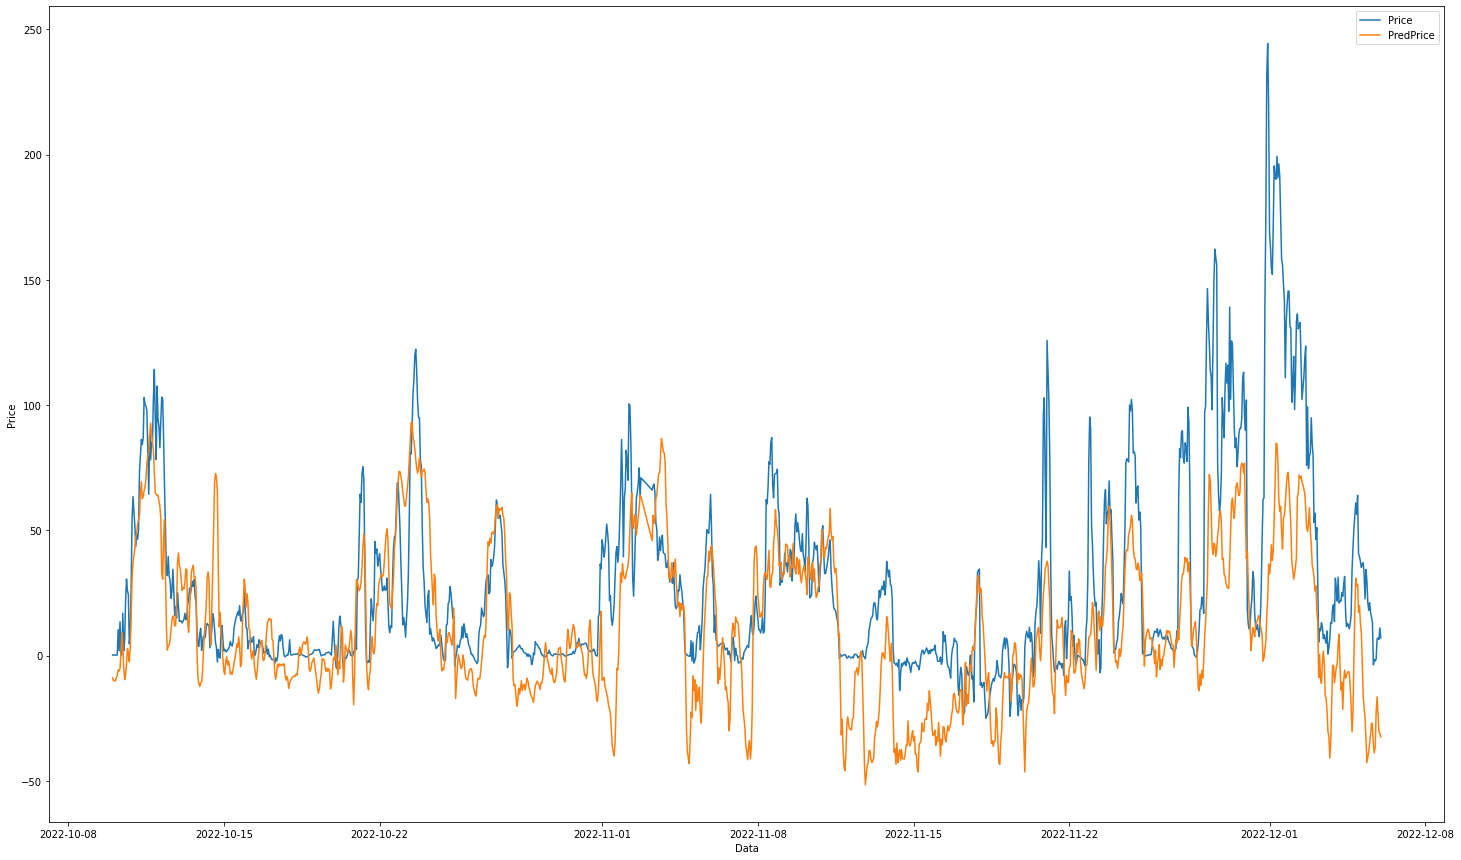

In [114]:
priceTest = pd.DataFrame(y_test, columns = ["Price"])
priceTest['PredPrice'] = y_pred
priceTest['Data'] = dataPred["Data"]


plt.rcParams['figure.figsize'] = (25,15)
sns.lineplot(data=priceTest, x='Data', y='Price', label="Price")
sns.lineplot(data=priceTest, x='Data', y='PredPrice', label="PredPrice")

# plt.ylim(0, 10)
plt.show()

## Графики зависимости от цены

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
fileAll="Z:\Dropbox (PowerMarketsUR)\Moscow Office\ERCOT\MCC_INFLUENCE\spp\model\dataset/CSWS.VOLT.0124_final.csv"
data = pd.read_csv(fileAll, low_memory=False)
data['Data'] = pd.to_datetime(data['Data'], format='%Y-%m-%d')

In [11]:
price = data[["Price", 'Data']].copy()
params = data[["Price","Wind", "Coal","Load","NaturalGas","PriceGaz","temp_mean"]].copy()

price_max  = price['Price'].max()
price_min  = price['Price'].min()

# scalerFeature = MinMaxScaler(feature_range=(price_min, price_max))

scalerFeature = MinMaxScaler()

feature = params[["Price", 'Wind', "Coal","Load","NaturalGas"]]

feature_scaler = scalerFeature.fit_transform(feature)
feature_scaler = pd.DataFrame(data=feature_scaler, columns=["Price",'Wind', "Coal","Load","NaturalGas"])

# feature_scaler["Price"] = price['Price']
feature_scaler["Data"] = price['Data']
feature_scaler

,Price,Wind,Coal,Load,NaturalGas,Data
0,0.230377,0.493315,0.427486,0.170944,0.149634,2022-04-01 00:00:00
1,0.232905,0.558098,0.410656,0.163777,0.086041,2022-04-01 01:00:00
2,0.239227,0.581077,0.393444,0.162899,0.082938,2022-04-01 02:00:00
3,0.236159,0.614136,0.365960,0.168761,0.080268,2022-04-01 03:00:00
4,0.234453,0.640431,0.379094,0.185875,0.088321,2022-04-01 04:00:00
...,...,...,...,...,...,...
5954,0.248227,0.658895,0.398776,0.308104,0.187701,2022-12-05 20:00:00
5955,0.249190,0.657221,0.390260,0.279534,0.180304,2022-12-05 21:00:00
5956,0.247246,0.644397,0.382891,0.238608,0.166688,2022-12-05 22:00:00
5957,0.261923,0.613504,0.366588,0.197600,0.153181,2022-12-05 23:00:00


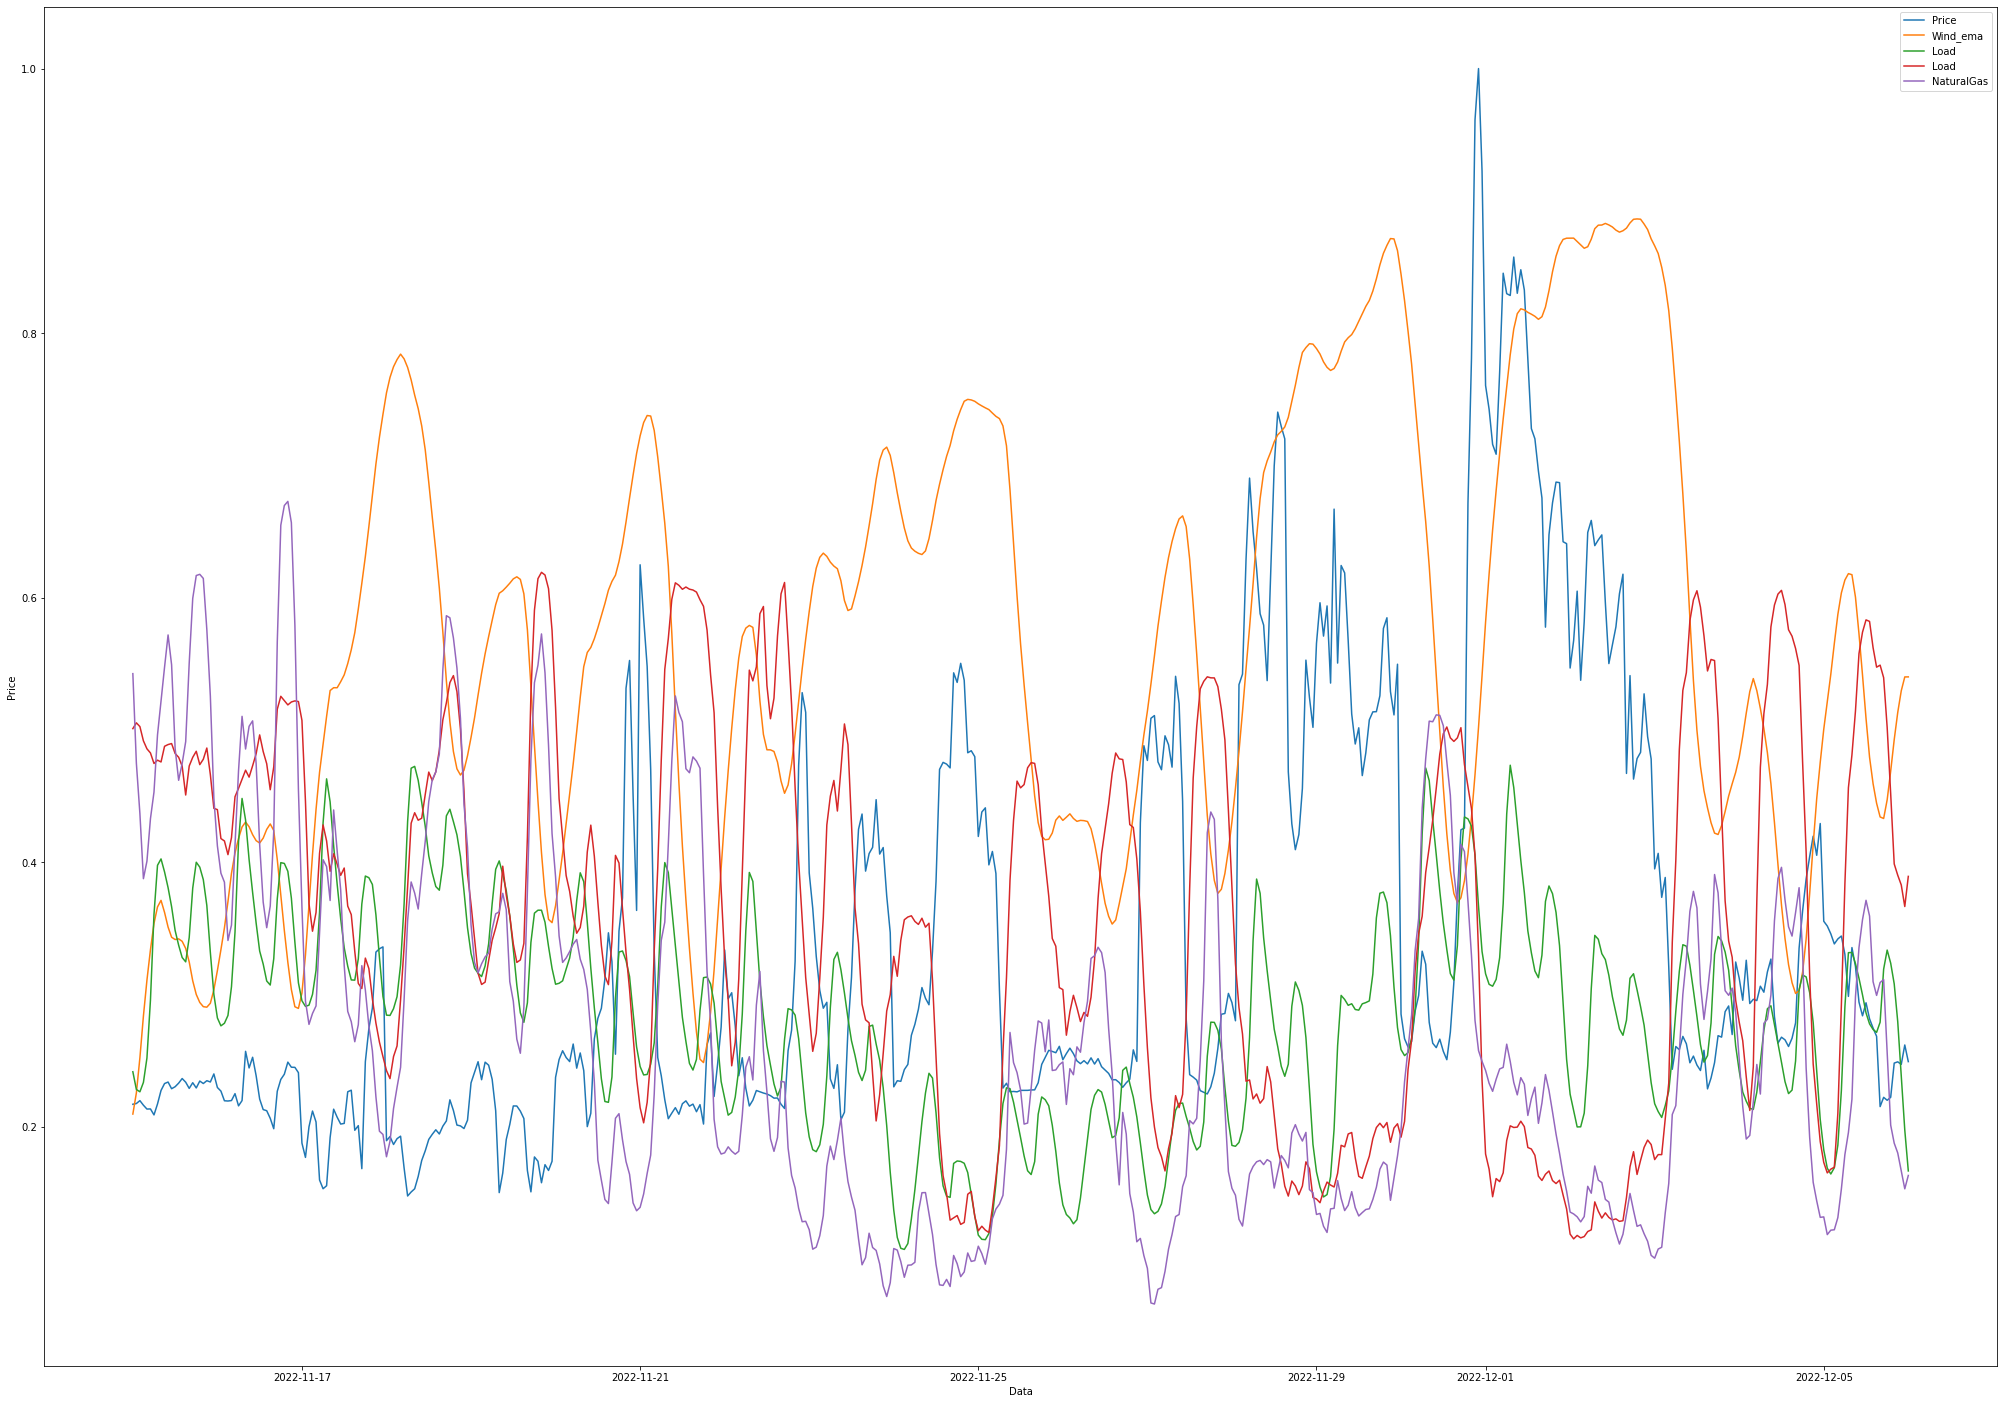

In [32]:

y = datetime.datetime(2022, 11, 15)

dataTrain = feature_scaler[(feature_scaler['Data'] >= y) ].copy()

dataTrain['Wind_ema'] = dataTrain['Wind'].ewm(span=15).mean()
dataTrain['Wind_ema'] = dataTrain['Wind'].ewm(span=15).mean()

plt.rcParams['figure.figsize'] = (35,25)
sns.lineplot(data=dataTrain, x='Data', y='Price', label="Price")
sns.lineplot(data=dataTrain, x='Data', y='Wind_ema', label="Wind_ema")

sns.lineplot(data=dataTrain, x='Data', y='Load', label="Load")
sns.lineplot(data=dataTrain, x='Data', y='Coal', label="Load")
sns.lineplot(data=dataTrain, x='Data', y='NaturalGas', label="NaturalGas")

# plt.ylim(0, 10)
plt.show()